In [285]:
import numpy as np 
from functools import reduce
import matplotlib.pyplot as plt

The framework of this code is provided by CUHKSZ CSC4020 course

## 1. Generate Data and Mask

In [601]:
def ifAnyAllMissed(mask):
    tmp = np.where(sum(mask.T) == 0)[0]
    if(len(tmp)) == 0:
        return False
    return True

def mask(X, missingRate):
    # assume X in np.array
    rowNum, colNum = X.shape
    mask = np.random.random(rowNum*colNum).reshape(rowNum,colNum) > missingRate
    while(ifAnyAllMissed(mask)):
        mask = np.random.random(rowNum*colNum).reshape(rowNum,colNum) > missingRate
    return mask

def dataGenerate(missingRate):
    ###set u and sigma
#     np.random.seed(1054) # for debug
    mu = np.array([0, 1, 2,4,8,10,20,50,80,100])
    Sigma=np.array([[10,4,8,4,10,4,4,0,6,8],
                    [ 4,6,2,4,6,4,4,2,2,4],
                    [ 8,2,10,4,10,6,2,0,4,8],
                    [ 4,4,4,8,6,8,4,4,2,6],
                    [10,6,10,6,18,10,8,4,8,12],
                    [ 4,4,6,8,10,12,6,6,4,8],
                    [ 4,4,2,4, 8, 6,8,4,6,4],
                    [ 0,2,0,4, 4, 6,4,6,2,2],
                    [ 6,2,4,2, 8, 4,6,2,8,4],
                    [ 8,4,8,6, 12,8,4,2,4,14]])
    ### generate true data
    n = 3000
    X_truth = np.random.multivariate_normal(mu, Sigma, n)
    rowNum, colNum = X_truth.shape
    ### generate in_c data:
    a_mask = mask(X_truth, missingRate)
    X_inc = X_truth.copy()
    X_inc[a_mask == False] = np.nan
    tru_missingRate = np.sum(X_inc == False)/(rowNum*colNum)
    ### return: [X_truth, X_inc, miss rate, real miss rate]
    return X_truth, X_inc, missingRate, tru_missingRate, a_mask, mu, Sigma

In [602]:
# sample
dataGenerate(0.4)[1][2]

array([         nan,          nan,          nan,   1.50197643,
                nan,  10.68919903,  19.18622235,  48.11563711,
        83.10873073, 100.58626406])

## 2. Model Construction

In [660]:
def em(missingRate, maxItrNum = 3000, eps = 1e-05):
    ### returned: [X_truth, X_inc, miss rate, real miss rate]
    X_truth, X_inc, _, tru_missingRate, a_mask, mu_truth, Sigma_truth = wholeData = dataGenerate(missingRate)
    rowNum, colNum = X_inc.shape
    Mu_truth = np.mean(X_truth,axis=0)
    Sigma_truth = np.cov(X_truth.T)
    ### hidden or visible
    aRange = np.array(range(1, 11, 1))
    hidden = aRange*(a_mask == False)-1
    visible = aRange*(a_mask)-1
    ### generate initial paras
    Mu = np.nanmean(X_inc, axis=0)
    c_rows_indices = np.where(np.isnan(sum(X_inc.T)) == False)[0]
    Sigma = np.cov(X_inc[c_rows_indices].T)
#     print(np.array([[round(ele2,1) for ele2 in ele] for ele in Sigma]))

    if np.isnan(Sigma).any():
        Sigma = np.diag(np.nanvar(X_inc, axis=0))
    ### iterations
    Mu_all = {}
    Sigma_all = {}
    X_now = X_inc.copy()
    convFlag = False
    his = []
    print('Model With MR=',missingRate," : ",end="")
    for i in range(maxItrNum):
        if i % 5 == 0: print('|',end="")
        if convFlag: break
        for r in range(rowNum):
            Sigma_all[r] = np.zeros(colNum**2).reshape(colNum,colNum)
            if -1 in visible[r]:
                hidden_i = [ele for ele in hidden[r] if ele != -1]
                visible_i = [ele for ele in visible[r] if ele != -1]
                Sigma_hh_i = Sigma[np.ix_(hidden_i,hidden_i)]
                Sigma_hv_i = Sigma[np.ix_(hidden_i,visible_i)]
                Sigma_vh_i = Sigma[np.ix_(visible_i,hidden_i)]
                Sigma_vv_i = Sigma[np.ix_(visible_i,visible_i)]
                ## according to the conditional p rule
                
                Mu_all[r] = Mu[np.ix_(hidden_i)]+Sigma_hv_i.dot(np.linalg.inv(Sigma_vv_i)).dot(X_now[r, visible_i]-Mu[np.ix_(visible_i)])
                X_now[r, hidden_i] = Mu_all[r]
                Sigma_all[r][np.ix_(hidden_i,hidden_i)]=Sigma_hh_i - Sigma_hv_i.dot(np.linalg.inv(Sigma_vv_i)).dot(Sigma_vh_i)
                
        Mu_new = np.mean(X_now, axis=0)
        Sigma_new = np.cov(X_now.T, bias = 1) + reduce(np.add, Sigma_all.values()) / rowNum
        convFlag = np.linalg.norm(Mu-Mu_new) <= eps and np.linalg.norm(Sigma-Sigma_new, ord = 2) <= eps
        if(convFlag): print('done')
        Mu = Mu_new
        Sigma = Sigma_new
        his.append(np.linalg.norm(Sigma-Sigma_truth))
    res = [Mu, Sigma, his, i, Mu_truth, Sigma_truth]
    return res 

## 3. Experiment

#### 3.1 MR = 0.4

In [613]:
Perc40Result = []
for i in range(10):
    Perc40Result.append(em(0.4))

Model With MR= 0.4  : |||||||||||||||||done
Model With MR= 0.4  : |||||||||||||||||done
Model With MR= 0.4  : |||||||||||||||||||||||done
Model With MR= 0.4  : ||||||||||||||||||||||done
Model With MR= 0.4  : |||||||||||||||||||||||||done
Model With MR= 0.4  : |||||||||||||||||||||||done
Model With MR= 0.4  : |||||||||||||||||||||done
Model With MR= 0.4  : ||||||||||||||||||||||||||||||||||||done
Model With MR= 0.4  : ||||||||||||||||||||||||||||done
Model With MR= 0.4  : ||||||||||||||||done


#### 3.2 MR = 0.3

In [612]:
Perc30Result = []
for i in range(10):
    Perc30Result.append(em(0.3))

Model With MR= 0.3  : ||||||||||done
Model With MR= 0.3  : ||||||||||done
Model With MR= 0.3  : ||||||||||||done
Model With MR= 0.3  : ||||||||||||done
Model With MR= 0.3  : |||||||||done
Model With MR= 0.3  : ||||||||done
Model With MR= 0.3  : ||||||||||done
Model With MR= 0.3  : |||||||||||done
Model With MR= 0.3  : ||||||||||||done
Model With MR= 0.3  : ||||||||done


#### 3.3 MR = 0.2

In [644]:
Perc20Result = []
for i in range(10):
    Perc20Result.append(em(0.2))

Model With MR= 0.2  : ||||||done
Model With MR= 0.2  : |||||||done
Model With MR= 0.2  : ||||||done
Model With MR= 0.2  : |||||||done
Model With MR= 0.2  : ||||||done
Model With MR= 0.2  : ||||||done
Model With MR= 0.2  : |||||||done
Model With MR= 0.2  : |||||||done
Model With MR= 0.2  : |||||||done
Model With MR= 0.2  : |||||||done


#### 3.4 MR = 0.1

In [643]:
Perc10Result = []
for i in range(10):
    Perc10Result.append(em(0.1))

Model With MR= 0.1  : |||done
Model With MR= 0.1  : |||done
Model With MR= 0.1  : |||done
Model With MR= 0.1  : |||done
Model With MR= 0.1  : |||done
Model With MR= 0.1  : |||done
Model With MR= 0.1  : |||done
Model With MR= 0.1  : |||done
Model With MR= 0.1  : |||done
Model With MR= 0.1  : |||done


#### 3.5 MR = 0.05

In [656]:
Perc5Result = []
for i in range(10):
    Perc5Result.append(em(0.05))

Model With MR= 0.05  : ||done!
Model With MR= 0.05  : ||done!
Model With MR= 0.05  : ||done!
Model With MR= 0.05  : ||done!
Model With MR= 0.05  : ||done!
Model With MR= 0.05  : ||done!
Model With MR= 0.05  : ||done!
Model With MR= 0.05  : ||done!
Model With MR= 0.05  : ||done!
Model With MR= 0.05  : ||done!


## 4. Report

In [706]:
def Mu_err(pre_Mu, real_Mu):
    mu = np.array([0, 1, 2,4,8,10,20,50,80,100])
    return np.linalg.norm(real_Mu-pre_Mu,2)/np.linalg.norm(real_Mu,2)
#     return np.linalg.norm(mu-pre_Mu,2)/np.linalg.norm(mu,2)

def Sigma_err(pre_Sigma, real_Sigma):
    Sigma_=np.array([[10,4,8,4,10,4,4,0,6,8],
                    [ 4,6,2,4,6,4,4,2,2,4],
                    [ 8,2,10,4,10,6,2,0,4,8],
                    [ 4,4,4,8,6,8,4,4,2,6],
                    [10,6,10,6,18,10,8,4,8,12],
                    [ 4,4,6,8,10,12,6,6,4,8],
                    [ 4,4,2,4, 8, 6,8,4,6,4],
                    [ 0,2,0,4, 4, 6,4,6,2,2],
                    [ 6,2,4,2, 8, 4,6,2,8,4],
                    [ 8,4,8,6, 12,8,4,2,4,14]])
    return np.linalg.norm(real_Sigma-pre_Sigma,2)/np.linalg.norm(real_Sigma,2)
#     return np.linalg.norm(Sigma_-pre_Sigma,2)/np.linalg.norm(Sigma_,2)

def Reporter(ResultsList, MRList=[0.4, 0.3, 0.2, 0.1, 0.05]):
    print('\t\tMu err Mean   \t\tMu err Std    \t\tSigma err Mean\t\tSigma err Std ')
    for resultIndex in range(len(ResultsList)):
        resTmp = ResultsList[resultIndex]
        MuErrs = [Mu_err(ele[0],ele[4]) for ele in resTmp]
        SigErrs = [Sigma_err(ele[1],ele[5]) for ele in resTmp]
        print("MR=",MRList[resultIndex],":\t",round(np.mean(MuErrs),4),'\t\t',round(np.std(MuErrs),5),'     ','\t\t',round(np.mean(SigErrs),5),'\t\t',round(np.std(SigErrs),5))
        

In [707]:
Reporter([Perc40Result,Perc30Result,Perc20Result,Perc10Result,Perc5Result])

		Mu err Mean   		Mu err Std    		Sigma err Mean		Sigma err Std 
MR= 0.4 :	 0.0006 		 0.00019       		 0.01097 		 0.00212
MR= 0.3 :	 0.0004 		 8e-05       		 0.00922 		 0.00159
MR= 0.2 :	 0.0002 		 7e-05       		 0.00684 		 0.00155
MR= 0.1 :	 0.0001 		 4e-05       		 0.00351 		 0.00091
MR= 0.05 :	 0.0001 		 2e-05       		 0.00203 		 0.0005


In [708]:
M_M = [np.mean([Mu_err(ele[0],ele[4]) for ele in ele2]) for ele2 in [Perc40Result,Perc30Result,Perc20Result,Perc10Result,Perc5Result]]
M_S = [np.std([Mu_err(ele[0],ele[4]) for ele in ele2]) for ele2 in [Perc40Result,Perc30Result,Perc20Result,Perc10Result,Perc5Result]]
S_M = [np.mean([Sigma_err(ele[1],ele[5]) for ele in ele2]) for ele2 in [Perc40Result,Perc30Result,Perc20Result,Perc10Result,Perc5Result]]
S_S = [np.std([Sigma_err(ele[1],ele[5]) for ele in ele2]) for ele2 in [Perc40Result,Perc30Result,Perc20Result,Perc10Result,Perc5Result]]
MR = [0.4, 0.3, 0.2, 0.1, 0.05]


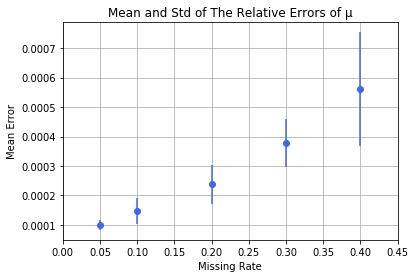

In [709]:
for i in range(len(M_M)):
    plt.errorbar(MR[i],M_M[i],M_S[i],fmt='-o',color='#4169E1')
plt.xlim(0,0.45)
plt.xlabel('Missing Rate')
# plt.ylim(0,0.008)
plt.ylabel('Mean Error')
plt.title('Mean and Std of The Relative Errors of μ')
plt.grid()
plt.show()

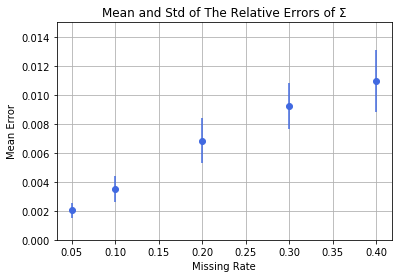

In [710]:
for i in range(len(S_M)):
    plt.errorbar(MR[i],S_M[i],S_S[i],fmt='-o',color='#4169E1')
# plt.xlim(0,0.45)
plt.xlabel('Missing Rate')
plt.ylim(0,0.015)
plt.ylabel('Mean Error')
plt.title('Mean and Std of The Relative Errors of Σ')
plt.grid()
plt.show()

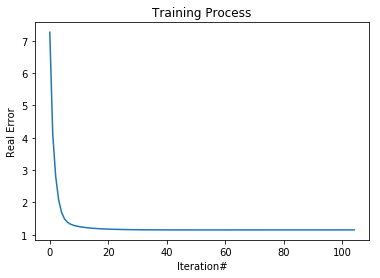

In [711]:
plt.plot(Perc40Result[3][2])
plt.title('Training Process')
plt.ylabel('Real Error')
plt.xlabel('Iteration#')
plt.show()